Evaluation results without cross-validation:
                     Accuracy   ROC AUC
Logistic Regression  0.949761  0.517908
Decision Tree        0.932057  0.573035
Random Forest        0.949282  0.545272
Dummy Classifier     0.950718  0.500000

Evaluation results with cross-validation (sorted by ROC AUC):
                     CV Accuracy (Mean)  CV Accuracy (Std)  CV ROC AUC (Mean)  \
Logistic Regression            0.934520           0.009204           0.716797   
Dummy Classifier               0.947253           0.000181           0.500000   
Decision Tree                  0.650851           0.309695           0.493697   
Random Forest                  0.753093           0.202974           0.422171   

                     CV ROC AUC (Std)  
Logistic Regression          0.084537  
Dummy Classifier             0.000000  
Decision Tree                0.080247  
Random Forest                0.208278  


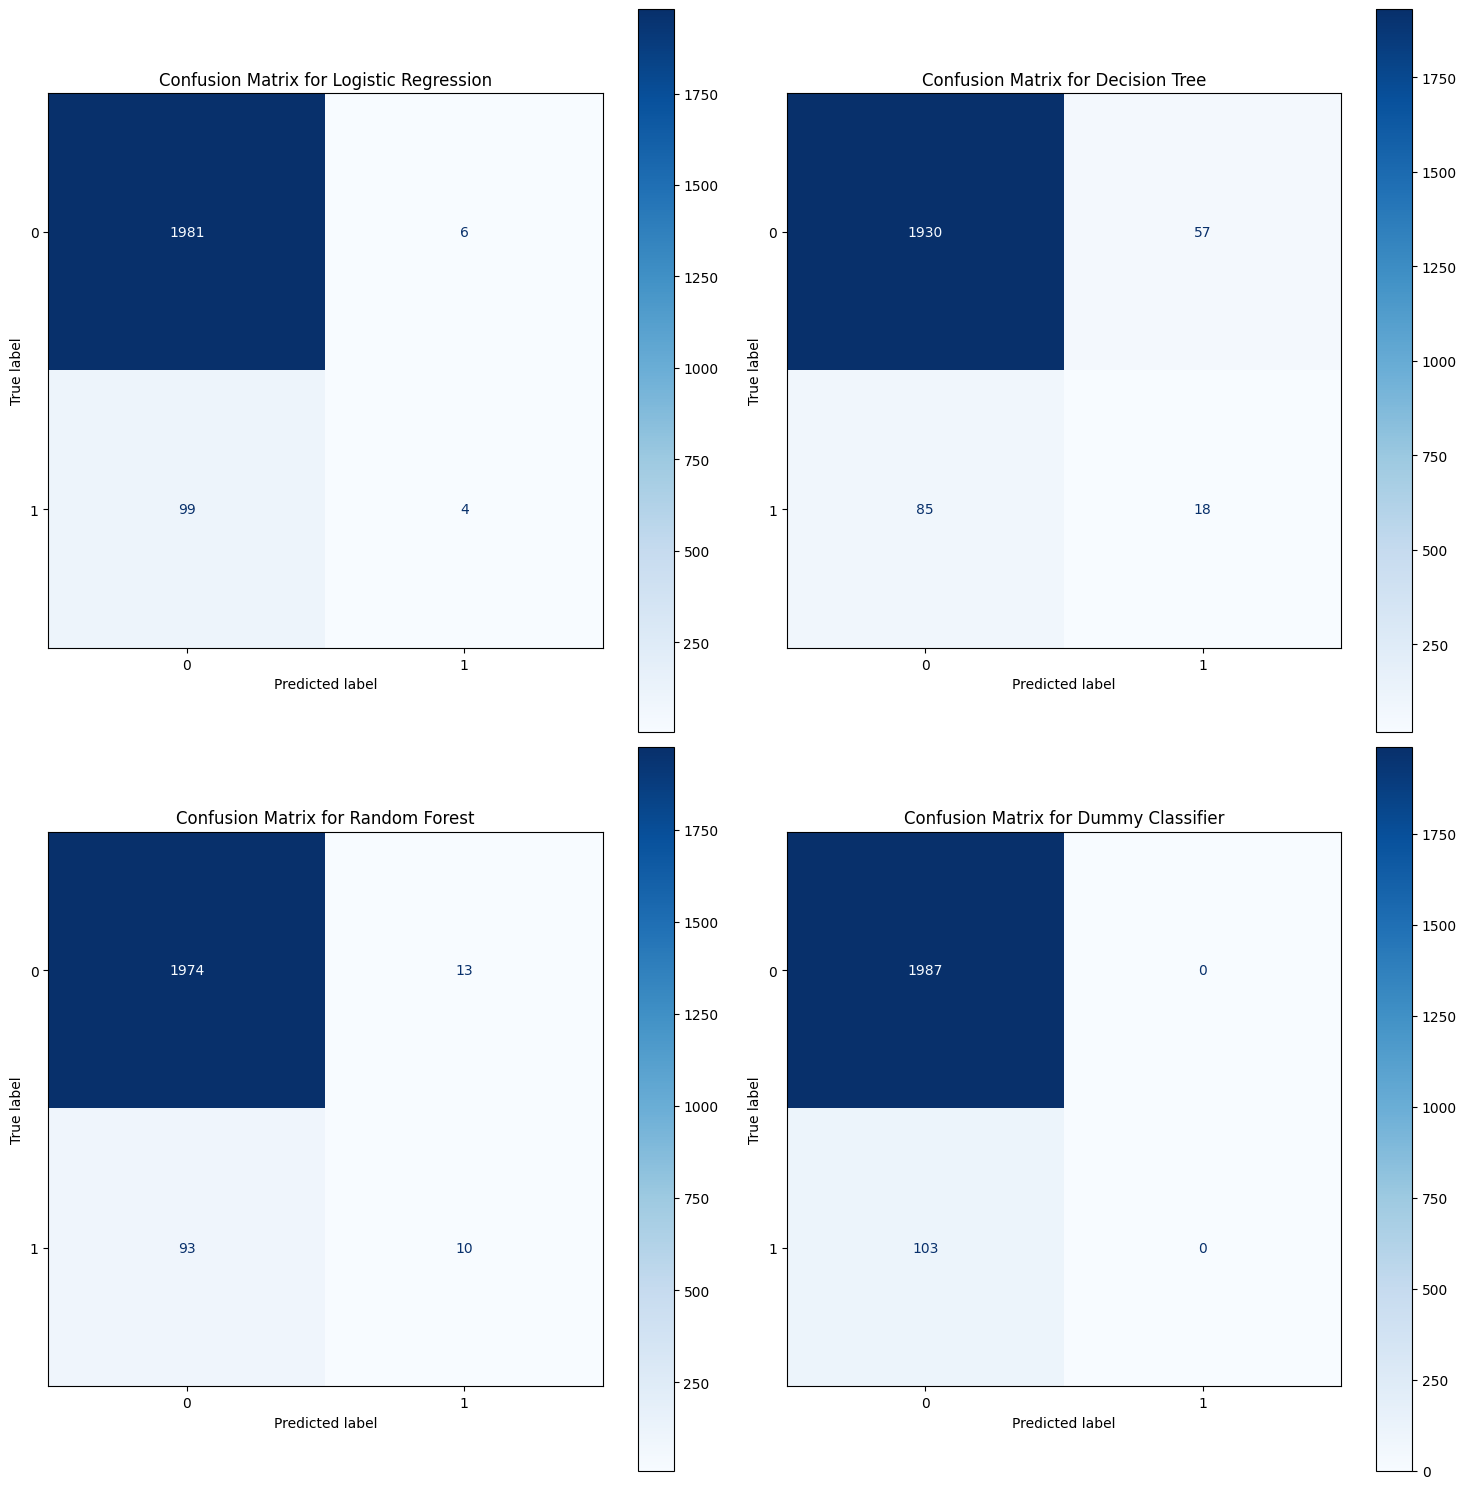

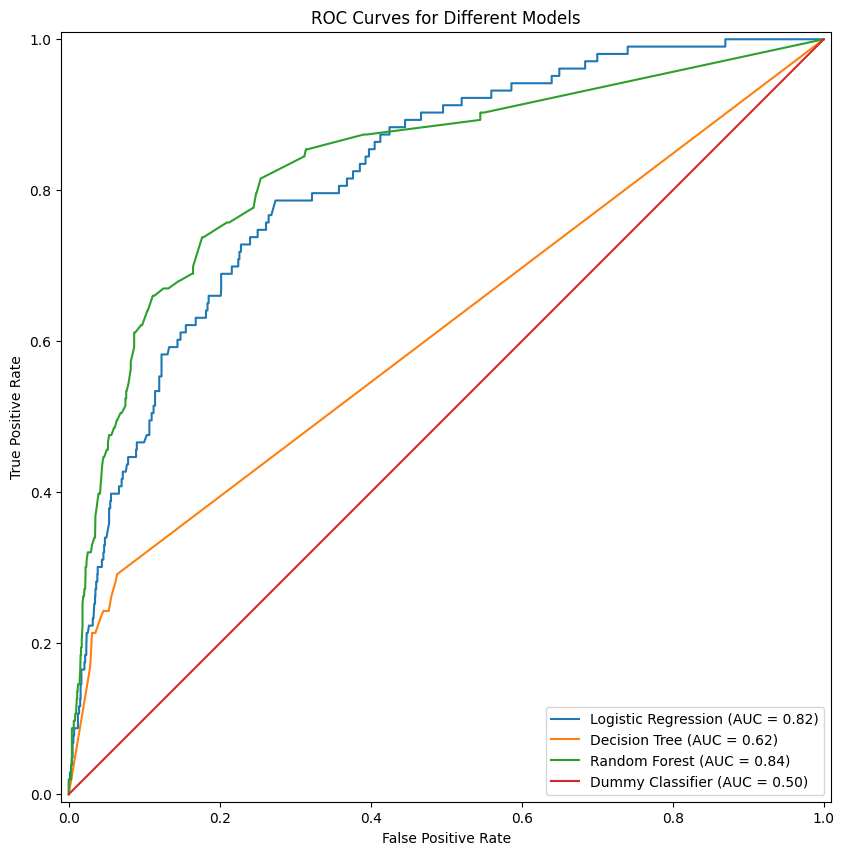

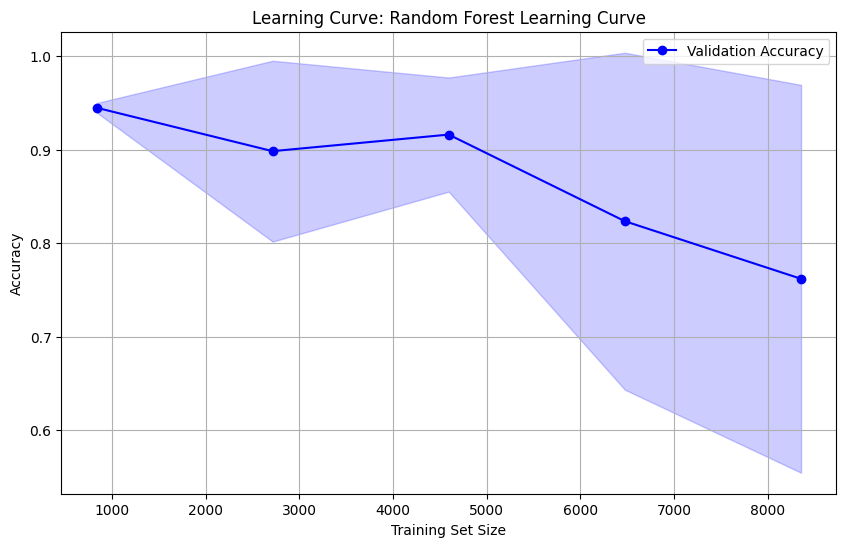

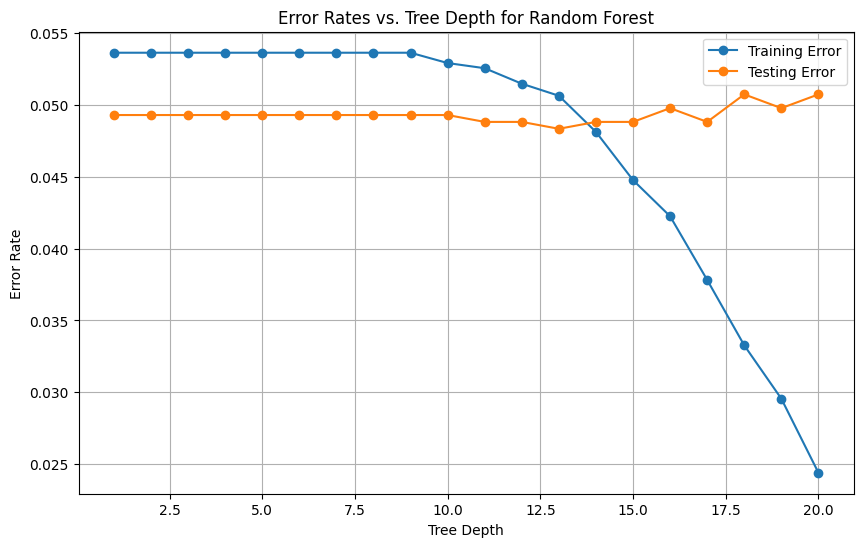

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, RocCurveDisplay

# Load data
data = pd.read_csv('../data/cleaned_train_encoded.csv')

# Split data into features and target
X = data.drop('WnvPresent', axis=1)
y = data['WnvPresent']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=10000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Dummy Classifier": DummyClassifier(strategy='most_frequent')
}

def plot_learning_curve(model, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, scoring='accuracy')
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, test_mean, marker='o', color='b', label='Validation Accuracy')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color='b')
    plt.title(f'Learning Curve: {title}')
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# Function to evaluate models with cross-validation
def evaluate_models_with_cv(models, X, y, cv=5):
    evaluation_results = {}

    for name, model in models.items():
        cv_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
        roc_auc_scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')

        evaluation_results[name] = {
            "CV Accuracy (Mean)": np.mean(cv_scores),
            "CV Accuracy (Std)": np.std(cv_scores),
            "CV ROC AUC (Mean)": np.mean(roc_auc_scores),
            "CV ROC AUC (Std)": np.std(roc_auc_scores)
        }

    return pd.DataFrame(evaluation_results).T

# Plot confusion matrices
def plot_confusion_matrices(trained_models, X_test, y_test):
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))

    for ax, (name, model) in zip(axes.flatten(), trained_models.items()):
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(ax=ax, cmap='Blues')
        ax.title.set_text(f'Confusion Matrix for {name}')

    plt.tight_layout()
    plt.show()

# Function to plot error rates vs tree depth for Random Forest
def plot_fitting_graph(X_train, y_train, X_test, y_test, depths):
    train_errors = []
    test_errors = []

    for depth in depths:
        rf = RandomForestClassifier(max_depth=depth, random_state=42)
        rf.fit(X_train, y_train)

        train_pred = rf.predict(X_train)
        test_pred = rf.predict(X_test)

        train_errors.append(1 - accuracy_score(y_train, train_pred))  # Error rate
        test_errors.append(1 - accuracy_score(y_test, test_pred))  # Error rate

    plt.figure(figsize=(10, 6))
    plt.plot(depths, train_errors, label='Training Error', marker='o')
    plt.plot(depths, test_errors, label='Testing Error', marker='o')
    plt.xlabel('Tree Depth')
    plt.ylabel('Error Rate')
    plt.title('Error Rates vs. Tree Depth for Random Forest')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot ROC curves
def plot_roc_curves(trained_models, X_test, y_test):
    fig, ax = plt.subplots(figsize=(10, 10))

    for name, model in trained_models.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]  # Get probability estimates for the positive class
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc_score(y_test, y_pred_proba), estimator_name=name)
        roc_display.plot(ax=ax)

    plt.title("ROC Curves for Different Models")
    plt.show()


# Train and evaluate models
trained_models, evaluation_results_df = evaluate_models(models, X_train, y_train, X_test, y_test)

# Display evaluation results without cross-validation
print("Evaluation results without cross-validation:")
print(evaluation_results_df)

# Evaluate models with cross-validation
evaluation_results_cv_df = evaluate_models_with_cv(models, X, y, cv=5)

# Sort evaluation results based on CV ROC AUC (Mean) in descending order
evaluation_results_cv_df_sorted = evaluation_results_cv_df.sort_values(by="CV ROC AUC (Mean)", ascending=False)

# Display evaluation results with cross-validation sorted by ROC AUC
print("\nEvaluation results with cross-validation (sorted by ROC AUC):")
print(evaluation_results_cv_df_sorted)

# Plot confusion matrices
plot_confusion_matrices(trained_models, X_test, y_test)

# Plot ROC curves
plot_roc_curves(trained_models, X_test, y_test)
plot_learning_curve(models['Random Forest'], X, y, title='Random Forest Learning Curve')
plot_fitting_graph(X_train, y_train, X_test, y_test, depths=range(1, 21))
